In [2]:
# Import required libraries
#!pip install seaborn
import os
import sys
import json
import random
from pathlib import Path

import cv2
import numpy as np
import pandas as pd 
from tqdm import tqdm

import seaborn as sns
import matplotlib.image as mpimg
from matplotlib import pyplot as plt


In [3]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [4]:
with open('/home/ec2-user/imaterialist/label_descriptions.json', 'r') as file:
    label_desc = json.load(file)
    
train_df = pd.read_csv('/home/ec2-user/imaterialist/train.csv')

In [5]:
train_df.head()

,ImageId,EncodedPixels,Height,Width,ClassId
0,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,6068157 7 6073371 20 6078584 34 6083797 48 608...,5214,3676,6
1,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,6323163 11 6328356 32 6333549 53 6338742 75 63...,5214,3676,0
2,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,8521389 10 8526585 30 8531789 42 8537002 46 85...,5214,3676,28
3,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,12903854 2 12909064 7 12914275 10 12919485 15 ...,5214,3676,31
4,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,10837337 5 10842542 14 10847746 24 10852951 33...,5214,3676,32


In [6]:
print(f'Image in training set: {train_df["ImageId"].nunique()}')

Image in training set: 45195


/tmp/ipykernel_7228/1077876571.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  image_shape_df = train_df.groupby("ImageId")["Height", "Width"].first()


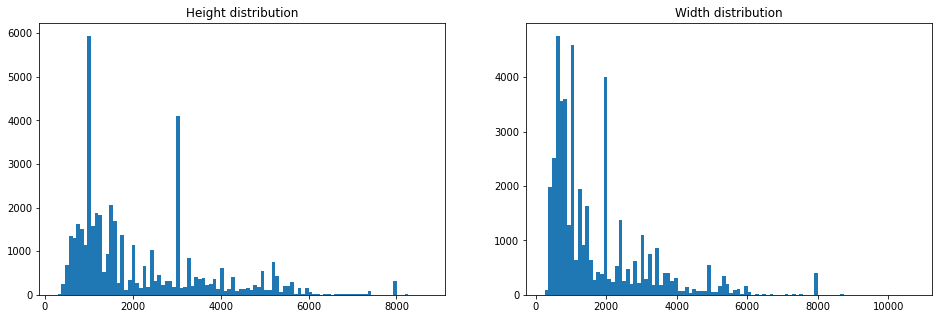

In [7]:
# Height and Width Stats
image_shape_df = train_df.groupby("ImageId")["Height", "Width"].first()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
ax1.hist(image_shape_df['Height'], bins=100)
ax1.set_title("Height distribution")
ax2.hist(image_shape_df['Width'], bins=100)
ax2.set_title("Width distribution")
plt.show()

#### Plot Data Sample

/home/ec2-user/imaterialist/train/b910b959d5f8180f1166b6c9e03601f6.jpg


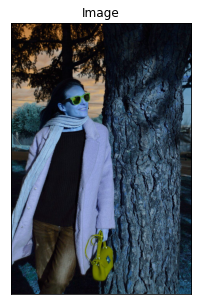

In [9]:
image_set = list(set(train_df['ImageId']))
folder_path = '/home/ec2-user/imaterialist/train/'
img_path = folder_path + image_set[0]
print(img_path)
visualize(image=cv2.imread(img_path))

/home/ec2-user/imaterialist/train/7ccae737f64205acf152c4d66437b4ba.jpg


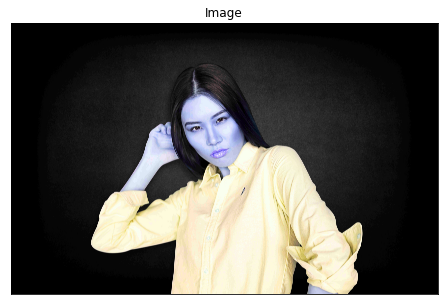

In [13]:
#Image with maximum Width
max_width = list(set(train_df[train_df['Width'] == train_df['Width'].max()]['ImageId']))[0]
img_path = folder_path + max_width
print(img_path)
visualize(image=cv2.imread(img_path))

### Train Image

In [29]:
image_paths = '/home/ec2-user/imaterialist/dataset/images/'
mask_paths = '/home/ec2-user/imaterialist/dataset/labels/'
image_set = os.listdir(image_paths)
mask_set = os.listdir(mask_paths)

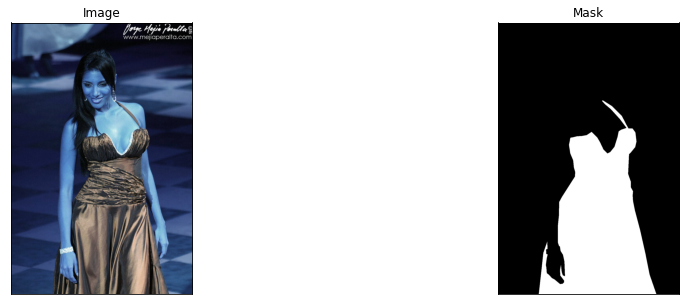

In [33]:
def show_sample(idx):
    img_path = image_paths + image_set[idx]
    mask_path = mask_paths + mask_set[idx]
    visualize(image=cv2.imread(img_path), mask=cv2.imread(mask_path))
    
show_sample(12)

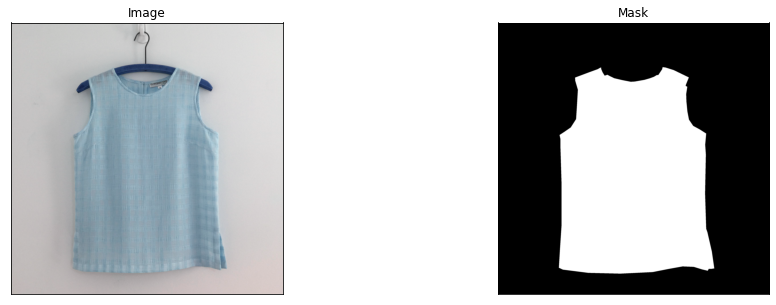

In [34]:
show_sample(1)

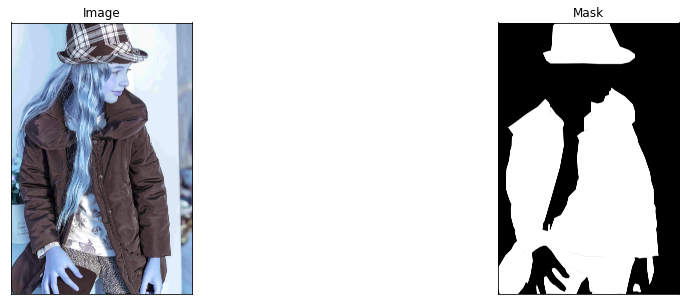

In [36]:
show_sample(1235)

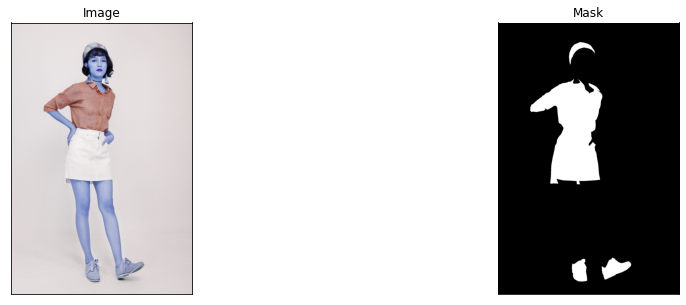

In [37]:
show_sample(14553)

In [38]:
cv2.imread(mask_path).shape

(2448, 2448, 3)

## Dataloaders

In [42]:
from pathlib import Path
from typing import Union, Dict, List, Tuple

def get_id2_file_paths(path):
    return {x.stem: x for x in Path(path).glob("*.*")}


def get_samples(image_path, mask_path):
    """Couple masks and images.
    Args:
        image_path:
        mask_path:
    """

    image2path = get_id2_file_paths(image_path)
    mask2path = get_id2_file_paths(mask_path)

    return [(image_file_path, mask2path[file_id]) for file_id, image_file_path in image2path.items()]

In [43]:
samples = get_samples(image_paths, mask_paths)

In [46]:
len(samples), samples[0]

(45193,
 (PosixPath('/home/ec2-user/imaterialist/dataset/images/00000663ed1ff0c4e0132b9b9ac53f6e.jpg'),
  PosixPath('/home/ec2-user/imaterialist/dataset/labels/00000663ed1ff0c4e0132b9b9ac53f6e.png')))

In [54]:
from iglovikov_helper_functions.utils.image_utils import load_rgb, load_grayscale
from pytorch_toolbelt.utils.torch_utils import tensor_from_rgb_image
from torch.utils.data import Dataset
import albumentations as albu
import torch

class SegmentationDataset(Dataset):
    def __init__(self, samples, augmentation=None, length=None):
        self.samples = samples
        self.augmentation = augmentation

        if length is None:
            self.length = len(self.samples)
        else:
            self.length = length

    def __len__(self) -> int:
        return self.length

    def __getitem__(self, idx):
        idx = idx % len(self.samples)

        image_path, mask_path = self.samples[idx]

        image = load_rgb(image_path, lib="cv2")
        mask = load_grayscale(mask_path)

        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample["image"], sample["mask"]

        mask = (mask > 0).astype(np.uint8)

        mask = torch.from_numpy(mask)

        return {
            "image_id": image_path.stem,
            "features": tensor_from_rgb_image(image),
            "masks": torch.unsqueeze(mask, 0).float(),
        }

In [55]:
dataset = SegmentationDataset(samples)

In [56]:
dataset[0]

/tmp/ipykernel_7228/2504150737.py:39: DeprecationWarning: Call to deprecated function tensor_from_rgb_image (This function is deprecated, please use image_to_tensor instead).
  "features": tensor_from_rgb_image(image),


{'image_id': '00000663ed1ff0c4e0132b9b9ac53f6e',
 'features': tensor([[[208, 208, 208,  ..., 208, 208, 208],
          [208, 208, 208,  ..., 208, 208, 208],
          [208, 208, 208,  ..., 208, 208, 208],
          ...,
          [208, 208, 208,  ..., 208, 208, 208],
          [208, 208, 208,  ..., 208, 208, 208],
          [208, 208, 208,  ..., 208, 208, 208]],
 
         [[209, 209, 209,  ..., 209, 209, 209],
          [209, 209, 209,  ..., 209, 209, 209],
          [209, 209, 209,  ..., 209, 209, 209],
          ...,
          [209, 209, 209,  ..., 209, 209, 209],
          [209, 209, 209,  ..., 209, 209, 209],
          [209, 209, 209,  ..., 209, 209, 209]],
 
         [[201, 201, 201,  ..., 201, 201, 201],
          [201, 201, 201,  ..., 201, 201, 201],
          [201, 201, 201,  ..., 201, 201, 201],
          ...,
          [201, 201, 201,  ..., 201, 201, 201],
          [201, 201, 201,  ..., 201, 201, 201],
          [201, 201, 201,  ..., 201, 201, 201]]], dtype=torch.uint8),
 '

In [73]:
def get_training_augmentation():
    train_transform = [
        
        albu.Resize(320,320),
        
        albu.HorizontalFlip(p=0.5),

        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        albu.RandomCrop(height=320, width=320, always_apply=True),

        albu.GaussNoise(p=0.2),

        albu.Normalize(max_pixel_value=255.0, mean = [.485,.456,.406], std=[.229,.224,.225], p=1)
        
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.Resize(400,400),
        albu.PadIfNeeded(400, 400),
        albu.Normalize(max_pixel_value=255.0, mean = [.485,.456,.406], std=[.229,.224,.225], p=1)
    ]
    return albu.Compose(test_transform)

In [74]:
dataset_augmented = SegmentationDataset(samples,augmentation=get_training_augmentation())

/tmp/ipykernel_7228/2504150737.py:39: DeprecationWarning: Call to deprecated function tensor_from_rgb_image (This function is deprecated, please use image_to_tensor instead).
  "features": tensor_from_rgb_image(image),
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


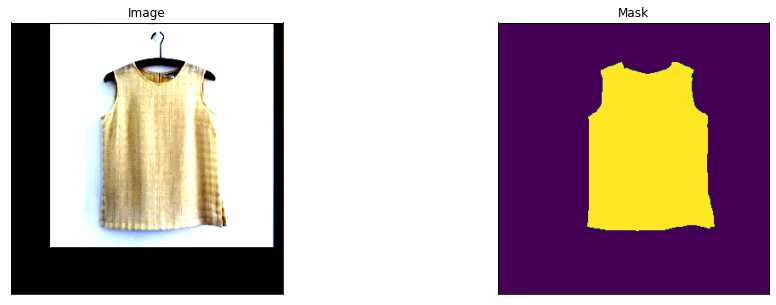

In [76]:
g = dataset_augmented[1]
visualize(image=np.transpose(g['features'],(1,2,0)), mask = g['masks'][0])
